In [57]:
import numpy as np
import pandas as pd
from importlib import reload
import amazon_parsing as ap
import ai_functions as aif
import seaborn as sns
import matplotlib.pyplot as plt
#reload(ap)

## Import Amazon product data and reviews
- Data description: https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/


In [58]:
json_parser = ap.AmazonJSONParser()
product_data_JA = json_parser.parser('./input/meta_AMAZON_FASHION.json')
review_data_JA = json_parser.parser('./input/AMAZON_FASHION.json')

product_data_LLM = product_data_JA.copy()
review_data_LLM = review_data_JA.copy()

# JA Workflow

## Initial data cleaning and EDA

In [59]:
print(product_data_JA.info())
print(review_data_JA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186637 entries, 0 to 186636
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            186632 non-null  object
 1   brand            139957 non-null  object
 2   feature          123875 non-null  object
 3   rank             180222 non-null  object
 4   date             185001 non-null  object
 5   asin             186637 non-null  object
 6   imageURL         132017 non-null  object
 7   imageURLHighRes  132017 non-null  object
 8   description      15869 non-null   object
 9   price            17799 non-null   object
 10  also_view        11595 non-null   object
 11  also_buy         21642 non-null   object
 12  fit              4831 non-null    object
 13  details          885 non-null     object
 14  similar_item     317 non-null     object
 15  tech1            97 non-null      object
dtypes: object(16)
memory usage: 22.8+ MB
None
<class 'pandas

Nearly every variable is qualitative. NLP is required on feature, description, and reviewText. NLP will extract: product sub-category, product features, key sentiments, and an overall sentiment rating.

From the product_data data frame, price and rank will be converted to numeric. From the review_data data frame, unixReviewTime will be converted to datetime.

The required variable to merge the datasets is asin. After creating product-specific features, I will self-merge in the top 'also_view' product attributes.

The required variables for the predicted outcome are overall, unixReviewTime, and rank.

The required variables for the independent features are feature, description, reviewText, overall, vote, and also_buy. 

In [60]:
# Clean numeric columns
# Price
product_data_JA['price'] = product_data_JA['price'].str.replace('$','')
product_data_JA['price'] = product_data_JA['price'].str.replace(',','')
multi_price_mask = product_data_JA['price'].str.contains(r'[^0-9.]', na=False)
product_data_JA['price'][multi_price_mask].value_counts()

# Take max price, since lower price is often a promotion for less popular items
product_data_JA['new_price'] = np.where(
    multi_price_mask,
    product_data_JA['price'].str.split('- ', expand=True)[1],
    product_data_JA['price']
)
product_data_JA['new_price'] = product_data_JA['new_price'].astype(float)

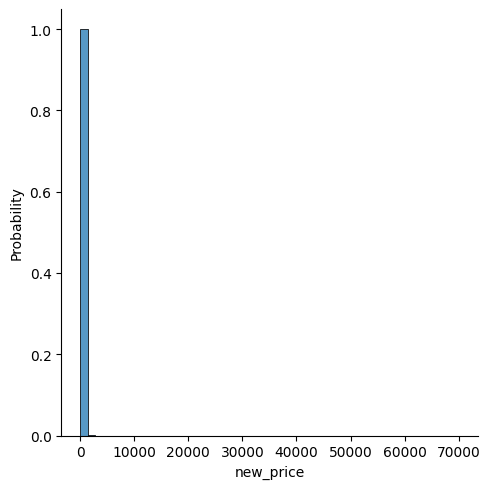

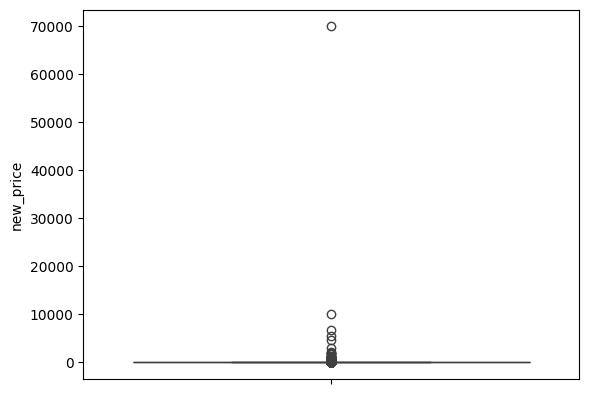

          new_price
count  17799.000000
mean      41.150485
std      539.639831
min        0.010000
25%       10.490000
50%       18.690000
75%       35.000000
max    69995.000000


In [61]:
# Plot
sns.displot(product_data_JA['new_price'],
            stat='probability',
            bins=50) 
plt.show()

plt.clf()
sns.boxplot(product_data_JA['new_price'])
plt.show()

print(product_data_JA.describe())

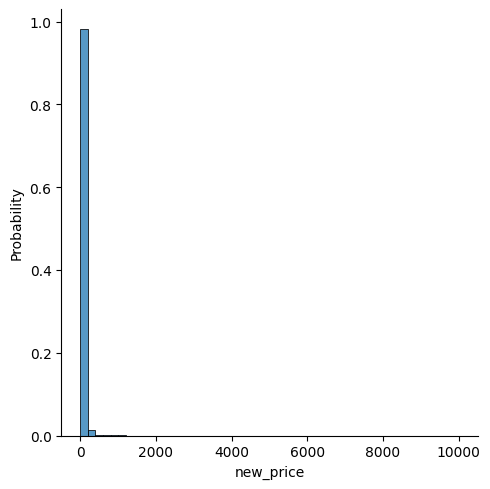

In [62]:
# Recode price outlier as NaN and plot again
product_data_JA['new_price'] = np.where(product_data_JA['new_price'] > 69990, np.nan , product_data_JA['new_price'])

sns.displot(product_data_JA['new_price'],
            stat='probability',
            bins=50) 
plt.show()

There are still a significant outliers and high values, especially considering the product category (clothes and accessories). Perpahs this is due to having taken the highest value of the range in the 'price' variable. What if I took the lower value of the price range when the max price exceeds the 95th percentile?

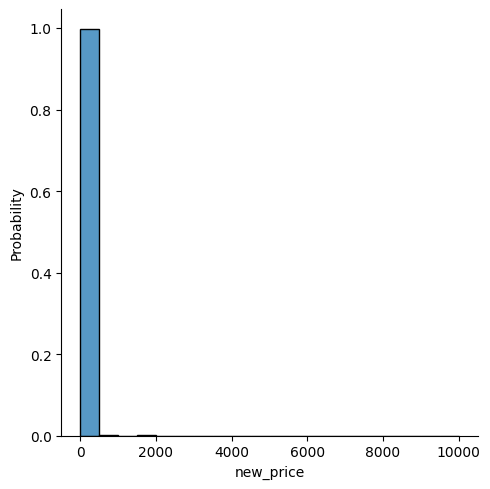

In [63]:
# Replace these with the lower value of the range and plot again.
pct_95_price = product_data_JA['new_price'].quantile(0.95)

product_data_JA['new_price'] = np.where(product_data_JA['new_price'] >= pct_95_price,
                                        product_data_JA['price'].str.split('- ', expand=True)[0].astype(float),
                                        product_data_JA['new_price']
                                        )

# Plot
sns.displot(product_data_JA['new_price'],
            stat='probability',
            bins=20)
plt.show()

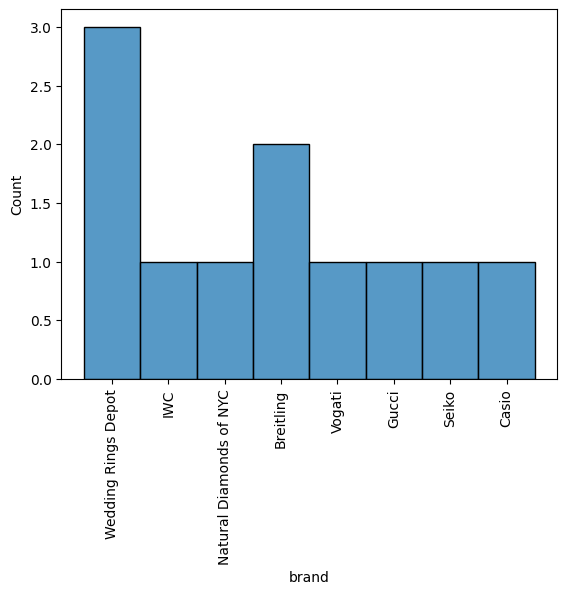

In [35]:
display(product_data_JA[product_data_JA['new_price'] > 3000].head(10))

sns.histplot(product_data_JA['brand'][product_data_JA['new_price'] > 1000])
plt.xticks(rotation=90)
plt.show()

It still appears that there are significant right-tail values. These are all luxury brands, however, so data cleaning appears sufficient.

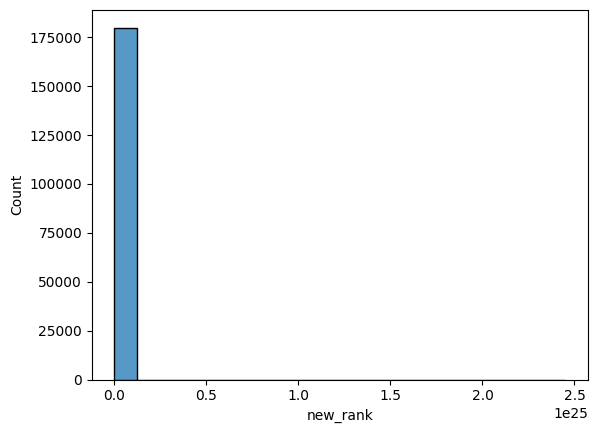

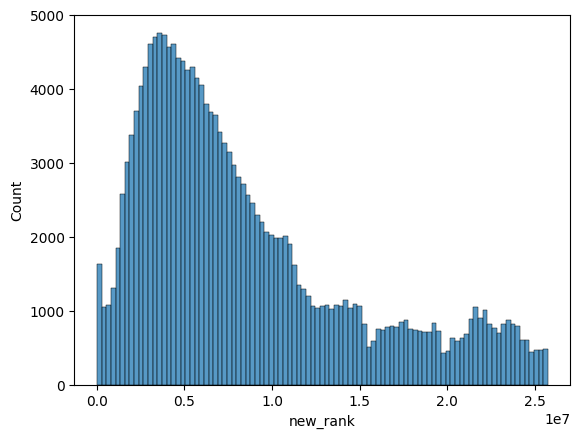

In [64]:
# Rank
product_data_JA['rank'] = product_data_JA['rank'].str.replace(r'[^0-9]', '', regex=True)
product_data_JA['new_rank'] = product_data_JA['rank'].str.split('in', expand=True)[0].astype(float)

# Plot all data
sns.histplot(product_data_JA['new_rank'], bins=20)
plt.show()

# Plot with 99th percentile
plt.clf()
sns.histplot(product_data_JA['new_rank'][product_data_JA['new_rank'] <= product_data_JA['new_rank'].quantile(q=.99)])
plt.show()

Another long right tail, which is surprising, since I would assume the distribution should be relatively uniform. It appears this is driven by large outliers. I'll trim this at the 99th percentile to account for them.

In [65]:
product_data_JA[product_data_JA['new_rank'] <= product_data_JA['new_rank'].quantile(q=.99)]

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,new_price,new_rank
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,13052976,8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13052976.0
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,11654581,5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11654581.0
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,19308073,5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19308073.0
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,19734184,5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19734184.0
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,10558646,5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,4.50,NaN,NaN,NaN,NaN,NaN,NaN,4.50,10558646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186632,JT Women's Elegant Off Shoulder Chiffon Maxi L...,JT,NaN,9835890,5 star,B01HJGXL4O,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9835890.0
186633,Microcosm Retro Vintage Black Crochet Lace One...,Microcosm,[Package Dimensions:\n \n7....,11390771,5 star5 star (0%),B01HJHF97K,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11390771.0
186634,Lookatool Classic Plain Vintage Army Military ...,Lookatool,"[Cotton+Polyester, Imported, Item type:Basebal...",972275,5 star,B01HJGJ9LS,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,8.53,"[B00XLECZMS, B0018MQAOY, B00N833I4Q, B074DQSPP...","[B07BHQ1FXL, B00XLECZMS, B07CJWM5WY, B07CS97C1...","class=""a-normal a-align-center a-spacing-smal...",NaN,NaN,NaN,8.53,972275.0
186635,Edith Windsor Women's Deep V-neck Beaded Sequi...,Edith Windsor,[Product Dimensions:\n \n9....,1964585,5 star,B01HJHTH5U,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,[B077ZLGMJ3],NaN,NaN,NaN,NaN,NaN,1964585.0


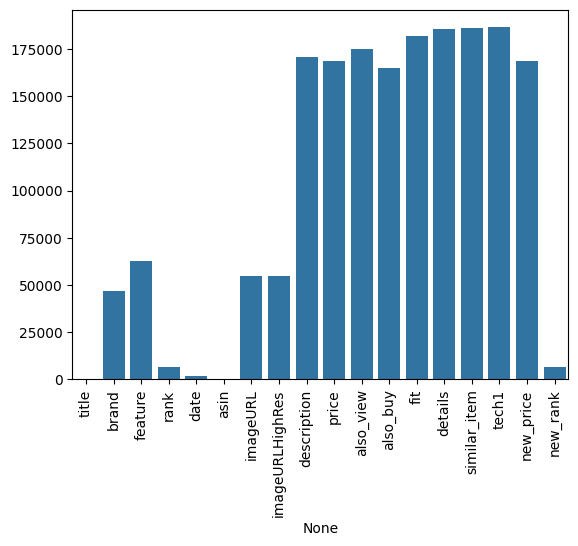

In [66]:
# Check missing values
sns.barplot(x=product_data_JA.isnull().sum().index, y=product_data_JA.isnull().sum().values)
plt.xticks(rotation=90)
plt.show()

## EDA summary 

### JA results

**From my own EDA, it appears that:**
- A majority of variables are qualitative and need natural language processing (NLP)
    - Will implement Topic Modeling + Aspect-Based Clutering as well as Word Embeddings + Sentiment flow to create unsupervised groupings of product and review characteristics.
- Quantiative variables (price and rank) needed minor cleaning and outlier removal.

**Next steps**
- Feature engineering
    - Implement NLP to get review and product characteristics
    - Create function to perform NLP at each stage of model testing and to monitor data drift over time.
- Model building
    - Create XGBoost, logistic regression, and random forest models
- Model testing
    - Using cross-validation, test model performances, choose model and report accuracy

## Feature engineering

### Perform NLP with TF-IDF + aspect-based clustering and word-embeddings + sentiment flow

### Create product-level overall and first-week attributes

In [ ]:
# Strategy 1: Topic Modeling + Aspect-Based Clustering
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import DBSCAN
from gensim.summarization.phrases import Phrases, Phraser
import spacy
from collections import defaultdict

def extract_features_and_sentiments(product_description, review_text):
    # Load spaCy model for dependency parsing
    nlp = spacy.load('en_core_web_sm')
    
    # 1. Product Sub-category and Feature Extraction
    def extract_noun_phrases(text):
        doc = nlp(text)
        noun_phrases = []
        for chunk in doc.noun_chunks:
            # Extract noun phrases with their modifiers
            if chunk.root.pos_ in ['NOUN', 'PROPN']:
                noun_phrases.append(chunk.text.lower())
        return noun_phrases
    
    # Extract candidate features from product description
    features = extract_noun_phrases(product_description)
    
    # Use TF-IDF to identify important terms
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
    tfidf_matrix = vectorizer.fit_transform([product_description])
    
    # Get top features based on TF-IDF scores
    feature_scores = dict(zip(vectorizer.get_feature_names_out(), 
                            tfidf_matrix.toarray()[0]))
    important_features = {k: v for k, v in sorted(feature_scores.items(), 
                         key=lambda x: x[1], reverse=True)[:10]}
    
    # 2. Review Sentiment Analysis
    def extract_aspect_sentiments(review):
        doc = nlp(review)
        aspect_sentiments = defaultdict(list)
        
        for sent in doc.sents:
            # Find sentiment-bearing words and their targets
            for token in sent:
                if token.pos_ in ['ADJ', 'ADV']:
                    # Find the closest noun phrase
                    target = None
                    for np in sent.noun_chunks:
                        if abs(token.i - np.root.i) <= 5:  # Within 5 tokens
                            target = np.text.lower()
                            break
                    
                    if target:
                        aspect_sentiments[target].append(token.text)
        
        return aspect_sentiments
    
    review_sentiments = extract_aspect_sentiments(review_text)
    
    return {
        'product_features': important_features,
        'aspect_sentiments': dict(review_sentiments)
    }

# Strategy 2: Word Embeddings + Sentiment Flow Analysis
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from textblob import TextBlob
import numpy as np

def analyze_product_and_sentiment(product_description, review_text):
    # 1. Feature Extraction using Word Embeddings
    def preprocess(text):
        # Basic preprocessing
        doc = nlp(text.lower())
        return ' '.join([token.lemma_ for token in doc 
                        if not token.is_stop and token.is_alpha])
    
    # Create document embeddings
    documents = [
        TaggedDocument(preprocess(product_description).split(), ['description']),
        TaggedDocument(preprocess(review_text).split(), ['review'])
    ]
    
    model = Doc2Vec(documents, vector_size=100, min_count=1, epochs=20)
    
    # Find similar words to common product feature indicators
    feature_indicators = ['feature', 'specification', 'includes', 'with']
    potential_features = []
    
    for indicator in feature_indicators:
        if indicator in model.wv:
            similar_words = model.wv.most_similar(indicator)
            potential_features.extend([word for word, _ in similar_words])
    
    # 2. Sentiment Flow Analysis
    def analyze_sentiment_flow(text):
        sentences = TextBlob(text).sentences
        sentiment_flow = []
        
        for sentence in sentences:
            # Get polarity score (-1 to 1)
            polarity = sentence.sentiment.polarity
            
            # Get key terms in sentence
            terms = [word for word, tag in sentence.tags 
                    if tag.startswith(('JJ', 'NN', 'RB'))]
            
            sentiment_flow.append({
                'polarity': polarity,
                'terms': terms
            })
        
        # Calculate overall sentiment
        overall_sentiment = np.mean([flow['polarity'] for flow in sentiment_flow])
        
        return {
            'sentiment_flow': sentiment_flow,
            'overall_sentiment': overall_sentiment
        }
    
    sentiment_analysis = analyze_sentiment_flow(review_text)
    
    return {
        'extracted_features': list(set(potential_features)),
        'sentiment_analysis': sentiment_analysis
    }

## Model specifications

I am trying to predict product success defined as:
- A rating above 4 stars one month after launch
- A rating above 4 starts one month after launch and high engagment (above the median number of reviews)
- A sales rank in the top 25% of a given product category
- A rating above 4.75 starts one month after launch

## Model evaluation



## Final output

In [56]:
from IPython.display import Markdown, display

display(Markdown(f"## Final model is x% accurate. \
                 \
                The most important features are X, X, and X.\
                My optimal approach would be X.  \
                The LLM's optimal approach would be:"))

## Final model is x% accurate.                                  The most important features are X, X, and X.                My optimal approach would be X.                  The LLM's optimal approach would be: